In [1]:
import pandas as pd
import pandas_profiling as pp
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import normalize
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster.hierarchy as shc
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [2]:
def define_pandas_options():
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.float_format', lambda x: '%.5f' % x)

In [16]:
pl_cols = ['gameId', 'playId', 'offense_h_play', 'offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived', 'offense_h_to_end', 'defense_h_play', 'defense_h_presnap', 'defense_h_to_throw', 'defense_h_to_arrived', 'defense_h_to_end', 'offense_p_play', 'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived', 'offense_p_to_end', 'offense_m_play', 'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived', 'offense_m_to_end', 'offense_v_play', 'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived', 'offense_v_to_end', 'offense_a_play', 'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived','offense_a_to_end', 'defense_p_play', 'defense_p_presnap','defense_p_to_throw', 'defense_p_to_arrived', 'defense_p_to_end','defense_m_play', 'defense_m_presnap', 'defense_m_to_throw','defense_m_to_arrived', 'defense_m_to_end', 'defense_v_play', 'defense_v_presnap', 'defense_v_to_throw', 'defense_v_to_arrived','defense_v_to_end', 'defense_a_play', 'defense_a_presnap','defense_a_to_throw', 'defense_a_to_arrived', 'defense_a_to_end','HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']

play_df = pd.read_csv('d20_intermediate_files/play_results.csv', usecols=pl_cols)
play_df['num_routes'] = play_df[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER', 'IN', 'ANGLE', 'POST', 'WHEEL']].T.sum()
play_df.drop(play_df[play_df['num_routes'] == 0].index, inplace=True)
play_df.dropna(inplace=True)

fr_cols = ['gameId', 'playId', 'frameId', 'offense_p_group', 'defense_p_group', 'offense_m_group', 'defense_m_group', 'o_state', 'd_state', 'offense_v_group', 'defense_v_group', 'offense_a_group', 'defense_a_group', 'a_group_ratio']
frame_df = pd.read_csv('d20_intermediate_files/frame_results.csv', usecols=fr_cols)

tr_cols = ['time', 's', 'a', 'dis', 'event', 'nflId', 'displayName', 'jerseyNumber', 'position', 'frameId', 'team', 'gameId', 'playId', 'playDirection', 'route', 'pos', 'teamType', 'o_vec', 'dir_vec', 'r_vec']
tracking_df = pd.read_csv('d20_intermediate_files/tracking_results.csv', usecols=tr_cols)

In [4]:
def string_to_vector(s):
    try:
        s = s.split('[')[1].split(']')[0]
        x = float(s.split()[0])
        y = float(s.split()[1])
        return np.array([x, y])
    except AttributeError:
        return None

def get_position_delta(row):
    return row.s / 10 * row.dir_vec

def get_relative_position(row):
    if row.frameId == 1:
        return np.array([0, 0])
    else:
        last_pos = row.shift(1).rel_pos
        return last_pos + row.pos_delta

In [5]:
tracking_df['pos'] = tracking_df['pos'].apply(string_to_vector)
tracking_df['o_vec'] = tracking_df['o_vec'].apply(string_to_vector)
tracking_df['dir_vec'] = tracking_df['dir_vec'].apply(string_to_vector)
tracking_df['r_vec'] = tracking_df['r_vec'].apply(string_to_vector)

# Clustering of play data

In [36]:
df = play_df[['gameId', 'playId', 'offense_h_presnap',
       'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap',
       'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
       'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_scaled = normalize(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns).drop(['gameId', 'playId'], axis=1)

## K-Means

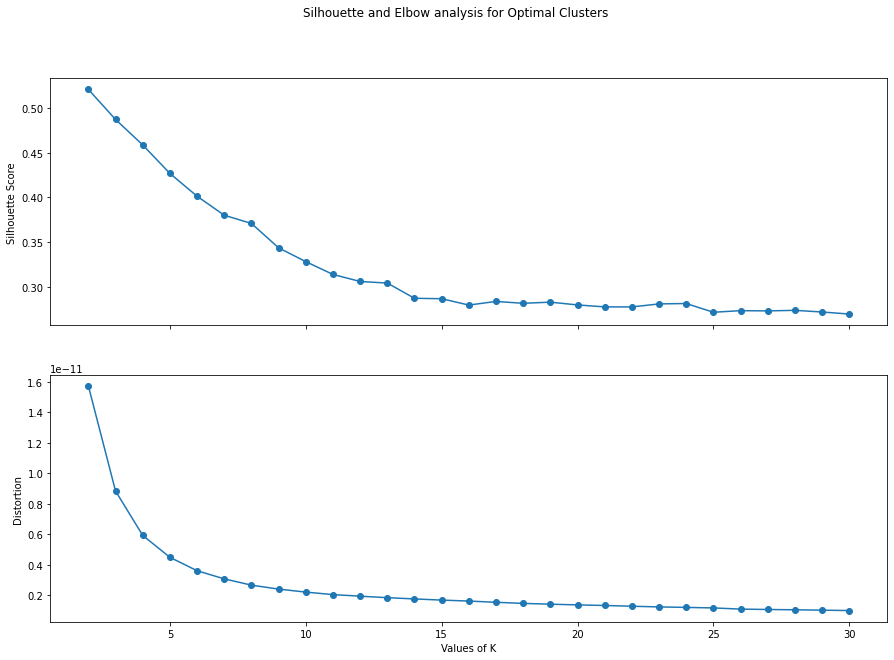

In [37]:
max_clusters = 30

range_clusters = []
for i in range(2, max_clusters + 1):
    range_clusters.append(i)

silhouette_avg = []
distortions = []

for i in range_clusters:
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(df_scaled)
    cluster_labels = km.labels_

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))
    distortions.append(km.inertia_)

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))
axs[0].plot(range_clusters, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')
axs[1].plot(range_clusters, distortions, marker='o')
axs[1].set_xlabel('Values of K')
axs[1].set_ylabel('Distortion')
fig.suptitle('Silhouette and Elbow analysis for Optimal Clusters')
plt.show()

In [46]:
k = 6
km = KMeans(
    n_clusters=k, init='random',
    n_init=3, max_iter=300,
    tol=1e-04, random_state=1
)

y_km = km.fit_predict(df_scaled)
df['clusters_kmeans'] = y_km

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

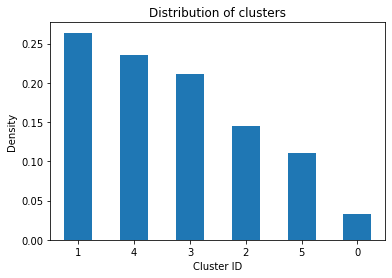

In [47]:
(df['clusters_kmeans'].value_counts()/df['clusters_kmeans'].value_counts().sum()).plot.bar(rot=0, title='Distribution of clusters', xlabel='Cluster ID', ylabel='Density')

In [49]:
print(df.shape)

(6052, 31)


## Agglomerative Clustering

### Silhouette testing on number of clusters

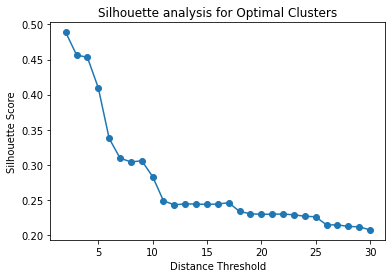

In [10]:
# Silhouette testing on n_clusters
range_clusters = []
n_samples = df_scaled.shape[0]
[range_clusters.append(x) for x in range(2, max_clusters + 1)]
silhouette_avg = []

for i in range_clusters:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=None,
                                n_clusters=i)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_clusters, silhouette_avg, marker='o')
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
plt.show()

### Silhouette testing on distance threshold

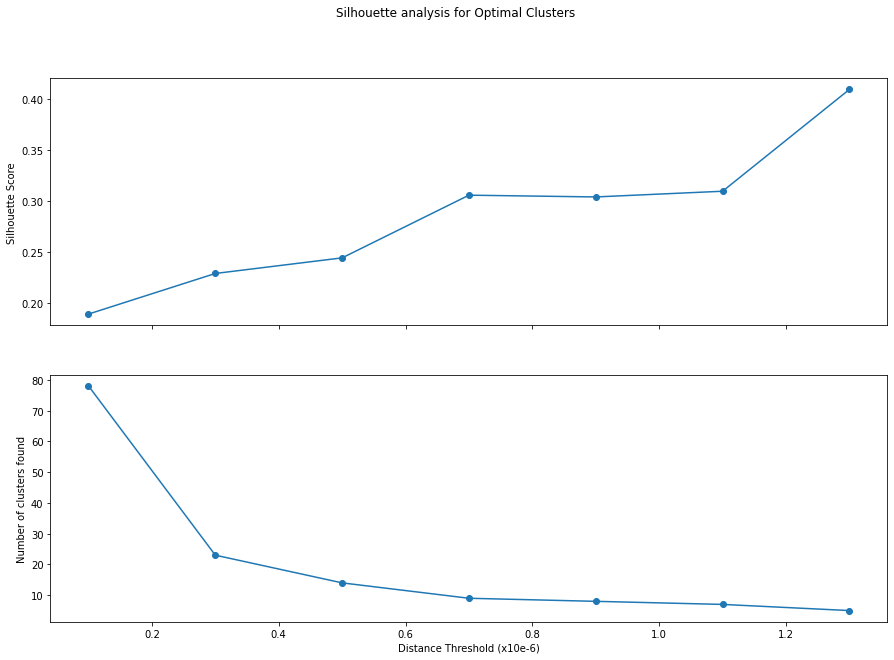

In [11]:
# Silhouette testing on limit
range_limit = [0.0000001, 0.0000003, 0.0000005, 0.0000007, 0.0000009, 0.0000011, 0.0000013]
n_samples = df_scaled.shape[0]

silhouette_avg = []
clusters_found = []

for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    clusters_found.append(np.unique(model.labels_).size)
    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(15,10))

axs[0].plot(np.array(range_limit) * 10**6, silhouette_avg, marker='o')
#axs[0].set_xlabel('Distance Threshold (x10e-6)')
axs[0].set_ylabel('Silhouette Score')

axs[1].plot(np.array(range_limit) * 10**6, clusters_found, marker='o')
axs[1].set_xlabel('Distance Threshold (x10e-6)')
axs[1].set_ylabel('Number of clusters found')
fig.suptitle('Silhouette analysis for Optimal Clusters')

plt.show()

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

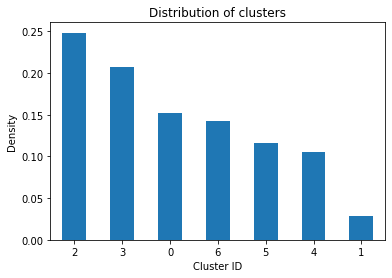

In [12]:
threshold = 1.1 * 10**-6
model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=threshold,
                                n_clusters=None)
model.fit(df_scaled)

df['clusters_agg'] = model.labels_
(df['clusters_agg'].value_counts() / df['clusters_agg'].value_counts().sum()).plot.bar(rot=0,
                                                                                             title='Distribution of clusters',
                                                                                             xlabel='Cluster ID',
                                                                                             ylabel='Density')

## Random Forest

In [13]:
features = df[['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']]
cols = ['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']
x_train, x_test, y_train, y_test = train_test_split(df[cols], df[['clusters_kmeans', 'clusters_agg']], test_size=0.4, shuffle=False, random_state=1)

In [14]:
y_train.shape

(3585, 2)

In [15]:
clf_k = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_k.fit(x_train, y_train['clusters_kmeans'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [16]:
clf_a = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clf_a.fit(x_train, y_train['clusters_agg'])

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

In [17]:
clf_a = RandomForestClassifier(n_jobs=-1, n_estimators=1000, max_depth=10)
clusters_a = df['clusters_agg']
clf_a.fit(features, clusters_a)

RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1)

<BarContainer object of 27 artists>

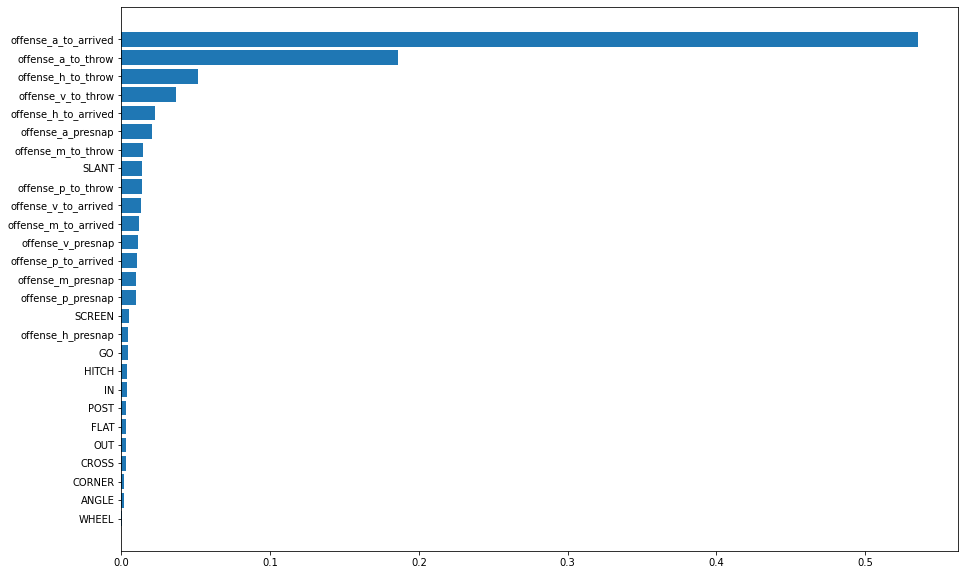

In [18]:
plt.figure(figsize=(15, 10))
sorted_idx_k = clf_k.feature_importances_.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], clf_k.feature_importances_[sorted_idx_k])

<BarContainer object of 27 artists>

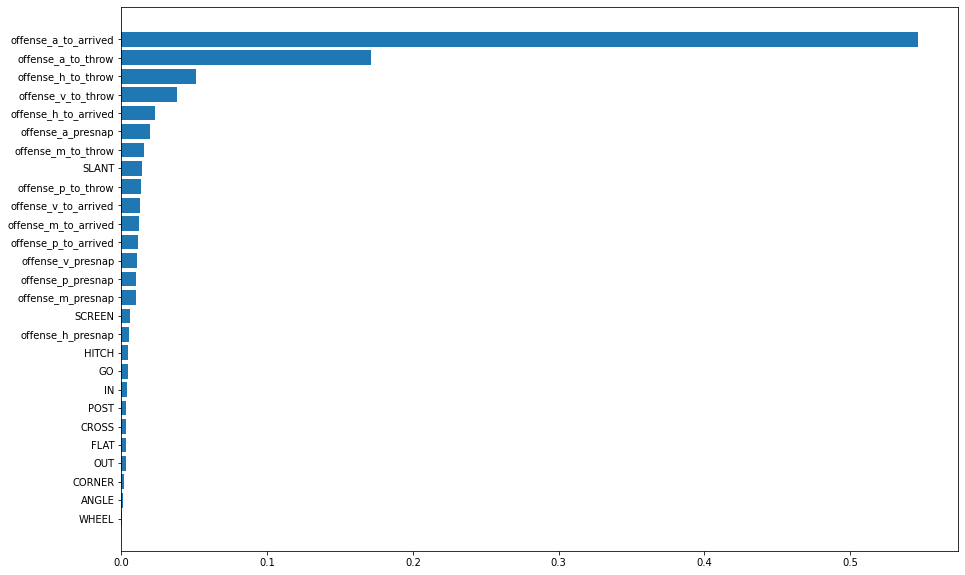

In [19]:
plt.figure(figsize=(15, 10))
sorted_idx_a = clf_a.feature_importances_.argsort()
plt.barh(clf_a.feature_names_in_[sorted_idx_a], clf_a.feature_importances_[sorted_idx_a])

In [20]:
perm_imp_k = permutation_importance(clf_k, x_train, y_train['clusters_kmeans'])

In [21]:
perm_imp_a = permutation_importance(clf_a, x_train, y_train['clusters_agg'])

<BarContainer object of 27 artists>

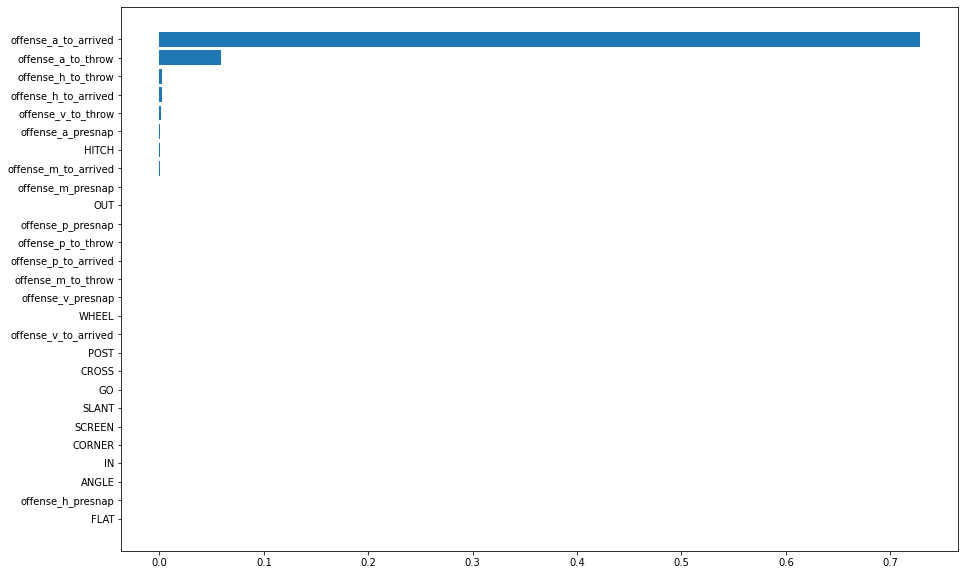

In [22]:
plt.figure(figsize=(15, 10))
sorted_idx_k = perm_imp_k.importances_mean.argsort()
plt.barh(clf_k.feature_names_in_[sorted_idx_k], perm_imp_k.importances_mean[sorted_idx_k])

<BarContainer object of 27 artists>

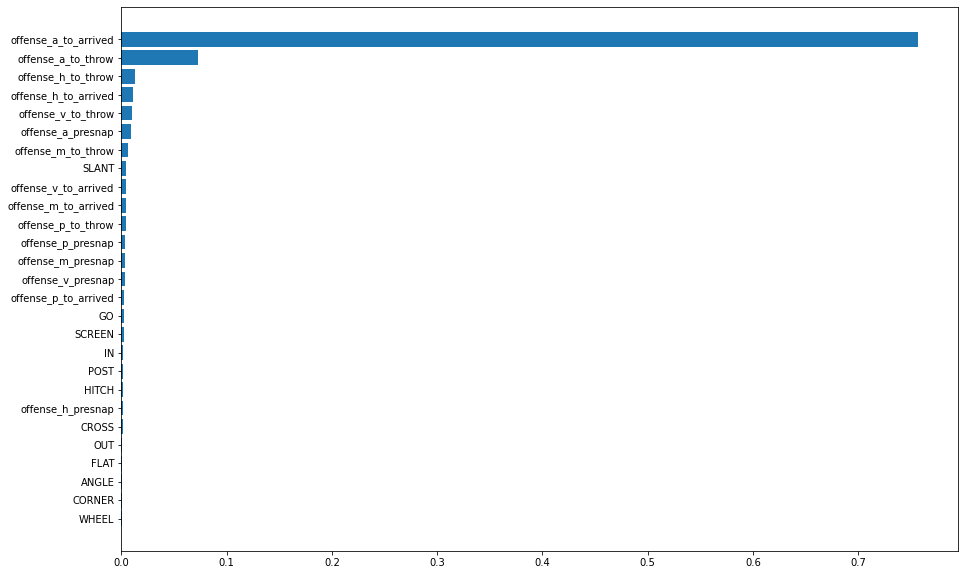

In [23]:
plt.figure(figsize=(15, 10))
sorted_idx_a = perm_imp_a.importances_mean.argsort()
plt.barh(clf_a.feature_names_in_[sorted_idx_a], perm_imp_a.importances_mean[sorted_idx_a])

In [24]:
#TODO: Accuracy scoring test

In [25]:
predicted = clf_k.predict(x_test)
print(
    f'Classification report for classifier {clf_k}:\n'
    f'{metrics.classification_report(y_test["clusters_kmeans"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       565
           1       1.00      0.69      0.81        80
           2       0.95      0.97      0.96       648
           3       0.99      0.97      0.98       336
           4       0.91      0.99      0.95       273
           5       0.97      0.96      0.96       489

    accuracy                           0.96      2391
   macro avg       0.96      0.92      0.94      2391
weighted avg       0.96      0.96      0.96      2391




Confusion Matrix:
[[547   0  15   3   0   0]
 [  0  55   0   0  25   0]
 [  9   0 628   0   0  11]
 [  9   0   0 327   0   0]
 [  0   0   0   0 269   4]
 [  0   0  19   0   2 468]]


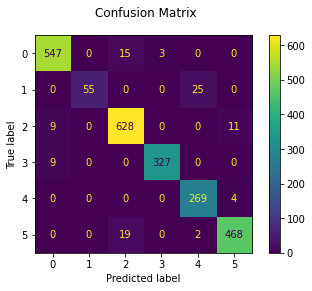

In [26]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_kmeans'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

In [27]:
predicted = clf_a.predict(x_test)
print(
    f'Classification report for classifier {clf_a}:\n'
    f'{metrics.classification_report(y_test["clusters_agg"], predicted)}\n'
)

Classification report for classifier RandomForestClassifier(max_depth=10, n_estimators=1000, n_jobs=-1):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       371
           1       1.00      0.99      0.99        72
           2       0.97      1.00      0.98       599
           3       0.99      1.00      0.99       493
           4       1.00      0.98      0.99       225
           5       0.99      0.94      0.97       290
           6       1.00      0.97      0.99       341

    accuracy                           0.99      2391
   macro avg       0.99      0.98      0.99      2391
weighted avg       0.99      0.99      0.99      2391




Confusion Matrix:
[[370   0   0   0   0   1   0]
 [  1  71   0   0   0   0   0]
 [  0   0 598   0   0   1   0]
 [  0   0   0 493   0   0   0]
 [  0   0   0   4 221   0   0]
 [  2   0  14   0   0 274   0]
 [  0   0   6   3   0   0 332]]


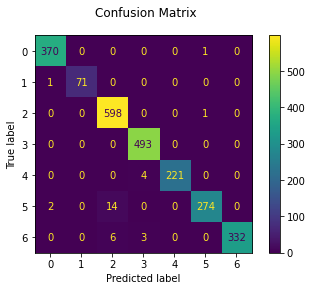

In [28]:
disp = metrics.ConfusionMatrixDisplay.from_predictions(y_test['clusters_agg'], predicted)
disp.figure_.suptitle('Confusion Matrix')
print(f'Confusion Matrix:\n{disp.confusion_matrix}')
plt.show()

[1e-06, 8.944444444444444e-07, 7.888888888888889e-07, 6.833333333333333e-07, 5.777777777777778e-07, 4.722222222222222e-07, 3.666666666666666e-07, 2.6111111111111113e-07, 1.5555555555555554e-07, 5e-08]


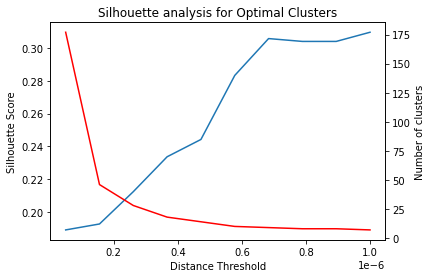

In [29]:
range_limit = []
[range_limit.append(n) for n in np.linspace(1*10**-6, 5*10**-8, 10)]
print(range_limit)
silhouette_avg = []
n_clusters = []
for i in range_limit:
    model = AgglomerativeClustering(linkage='ward',
                                affinity='euclidean',
                                distance_threshold=i,
                                n_clusters=None)
    model.fit(df_scaled)
    cluster_labels = model.labels_
    n_clusters.append(len(np.unique(model.labels_)))

    silhouette_avg.append(silhouette_score(df_scaled, cluster_labels))

fig, ax = plt.subplots()
ax.plot(range_limit, silhouette_avg)
ax.set_xlabel('Distance Threshold')
ax.set_ylabel('Silhouette Score')
ax.set_title('Silhouette analysis for Optimal Clusters')
ax2 = ax.twinx()
ax2.plot(range_limit, n_clusters, color='r')
ax2.set_ylabel('Number of clusters')
plt.show()

In [30]:
agglom_sizes = df.groupby('clusters_agg').size()
agglom_sizes

clusters_agg
0     908
1     173
2    1484
3    1235
4     628
5     697
6     851
dtype: int64

In [31]:
df.head()

,gameId,playId,offense_h_presnap,offense_h_to_throw,offense_h_to_arrived,offense_p_presnap,offense_p_to_throw,offense_p_to_arrived,offense_m_presnap,offense_m_to_throw,...,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL,num_routes,clusters_kmeans,clusters_agg
0,2018090600,75,-0.000000,4.733452,4.306341,0.491735,0.586294,0.488032,0.455213,0.265324,...,0,0,0,0,0,0,0,4,0,6
1,2018090600,146,0.722081,4.249899,3.185872,0.466888,0.413593,0.501455,0.352721,0.198450,...,0,0,0,0,0,0,0,5,0,3
3,2018090600,190,-0.000000,5.278721,4.789590,0.368274,0.272067,0.305495,0.325148,0.405869,...,0,0,1,1,0,0,0,3,0,6
4,2018090600,256,0.592412,3.949740,4.065981,0.521001,0.355874,0.586696,0.222165,0.272859,...,0,0,0,0,0,0,0,3,0,3
5,2018090600,320,0.856801,4.486656,4.609067,0.203906,0.588602,0.382720,0.103318,0.213341,...,0,0,0,0,1,0,0,5,0,3


In [32]:
df.groupby('clusters_agg')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

clusters_agg,0,1,2,3,4,5,6
HITCH,0.754405,0.468208,0.828841,0.662348,0.273885,0.789096,0.792009
OUT,0.509912,0.514451,0.471024,0.464777,0.211783,0.523673,0.454759
FLAT,0.628855,0.763006,0.609838,0.761943,0.917197,0.573888,0.600470
CROSS,0.397577,0.346821,0.453504,0.367611,0.246815,0.368723,0.459459
GO,1.046256,1.283237,0.873989,0.702024,0.775478,1.034433,0.769683
SLANT,0.041850,0.040462,0.178571,0.666397,0.606688,0.076040,0.424207
SCREEN,0.112335,0.144509,0.145553,0.246154,0.767516,0.139168,0.149236
CORNER,0.198238,0.196532,0.162399,0.113360,0.038217,0.164993,0.156287
IN,0.350220,0.236994,0.436658,0.201619,0.062102,0.397418,0.368978
ANGLE,0.186123,0.156069,0.163747,0.159514,0.243631,0.192253,0.141011


In [33]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().T

gameId,2018090600,2018090900,2018090901,2018090902,2018090903,2018090905,2018090906,2018090907,2018090909,2018090910,...,2018123006,2018123007,2018123008,2018123009,2018123010,2018123011,2018123012,2018123013,2018123014,2018123015
HITCH,0.953488,0.764706,0.500000,0.736842,0.629630,0.8750,0.470588,0.333333,1.000000,0.894737,...,0.8750,0.20,1.103448,0.809524,0.733333,0.785714,0.846154,0.529412,0.666667,0.565217
OUT,0.348837,0.294118,0.291667,0.526316,0.629630,0.3125,0.352941,0.523810,0.526316,0.421053,...,0.1250,0.55,0.655172,0.666667,0.533333,0.392857,0.423077,0.529412,0.541667,0.739130
FLAT,0.790698,0.764706,0.666667,0.526316,0.555556,0.6250,0.647059,0.666667,1.157895,0.473684,...,0.5625,0.50,0.724138,0.380952,0.633333,0.857143,0.730769,0.470588,0.666667,0.347826
CROSS,0.511628,0.235294,0.416667,0.263158,0.333333,0.1250,0.117647,0.476190,0.263158,0.578947,...,0.3125,0.70,0.241379,0.333333,0.533333,0.428571,0.807692,0.294118,0.500000,0.434783
GO,0.813953,0.941176,1.208333,0.736842,1.000000,1.2500,0.882353,0.857143,0.473684,0.578947,...,0.6875,0.80,0.896552,0.952381,0.633333,0.785714,0.500000,0.647059,0.833333,0.652174
SLANT,0.162791,0.352941,0.291667,0.210526,0.259259,0.5000,0.352941,0.285714,0.368421,0.315789,...,0.7500,0.30,0.413793,0.190476,0.100000,0.250000,0.269231,0.235294,0.250000,0.173913
SCREEN,0.069767,0.117647,0.583333,0.368421,0.185185,0.1875,0.294118,0.285714,0.263158,0.263158,...,0.2500,0.35,0.172414,0.523810,0.433333,0.178571,0.153846,0.176471,0.166667,0.260870
CORNER,0.139535,0.117647,0.125000,0.105263,0.074074,0.0625,0.235294,0.190476,0.368421,0.157895,...,0.2500,0.10,0.103448,0.000000,0.333333,0.214286,0.115385,0.411765,0.166667,0.086957
IN,0.441860,0.294118,0.250000,0.315789,0.481481,0.3125,0.411765,0.285714,0.210526,0.473684,...,0.1250,0.25,0.275862,0.476190,0.233333,0.285714,0.461538,0.529412,0.208333,0.434783
ANGLE,0.093023,0.176471,0.166667,0.263158,0.333333,0.1250,0.294118,0.142857,0.105263,0.210526,...,0.1250,0.20,0.068966,0.190476,0.200000,0.071429,0.038462,0.294118,0.125000,0.173913


<AxesSubplot:title={'center':'Average routes per play per game'}, ylabel='Number per play'>

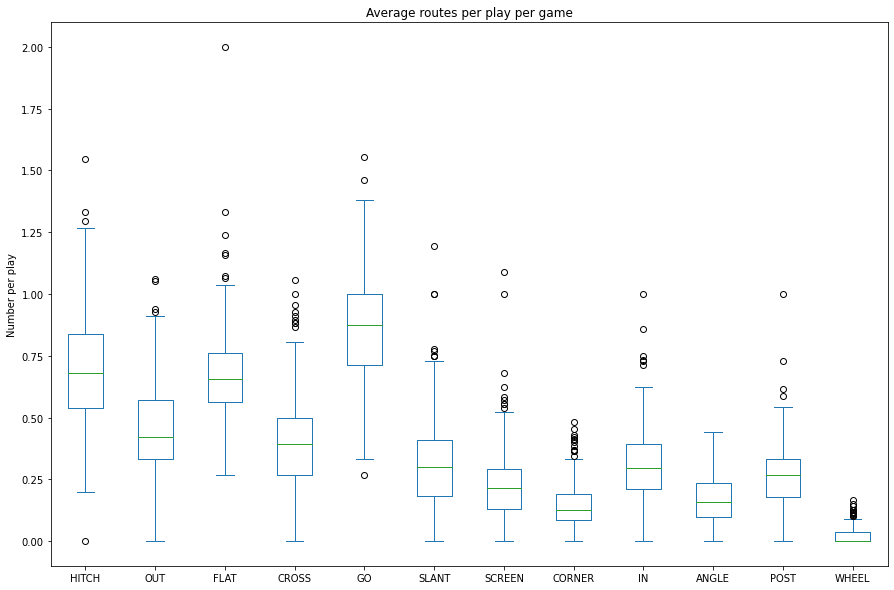

In [34]:
df.groupby(['gameId'])[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per game')

<AxesSubplot:title={'center':'Average routes per play per cluster'}, ylabel='Number per play'>

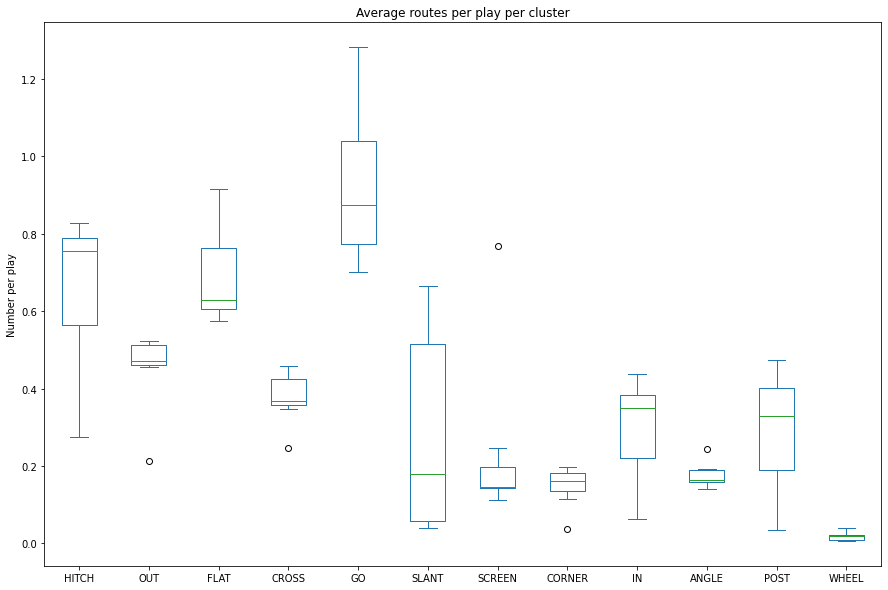

In [35]:
df.groupby('clusters_agg')[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']].mean().plot.box(figsize=(15,10), xlabel='Route', ylabel='Number per play', title='Average routes per play per cluster')

In [36]:
cluster0 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 0)]
cluster0.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.15683
offense_h_to_throw        5.04606
offense_h_to_arrived      4.14132
offense_p_presnap         0.44148
offense_p_to_throw        0.50631
offense_p_to_arrived      0.52009
offense_m_presnap         0.24822
offense_m_to_throw        0.31332
offense_m_to_arrived      0.31216
offense_v_presnap         0.03072
offense_v_to_throw        0.77079
offense_v_to_arrived      0.92983
offense_a_presnap        72.49037
offense_a_to_throw      207.37815
offense_a_to_arrived    542.47701
HITCH                     0.75441
OUT                       0.50991
FLAT                      0.62885
CROSS                     0.39758
GO                        1.04626
SLANT                     0.04185
SCREEN                    0.11233
CORNER                    0.19824
IN                        0.35022
ANGLE                     0.18612
POST                      0.41189
WHEEL                     0.01322
num_routes                4.65088
clusters_kmeans           4.18282
dtype: object

In [37]:
cluster2 = df.drop(['gameId', 'playId', 'clusters_agg'], axis=1).loc[(df['clusters_agg'] == 2)]
cluster2.mean().apply(lambda x: '%.5f' % x)

offense_h_presnap         0.17329
offense_h_to_throw        4.79730
offense_h_to_arrived      3.98415
offense_p_presnap         0.43350
offense_p_to_throw        0.50275
offense_p_to_arrived      0.52270
offense_m_presnap         0.24926
offense_m_to_throw        0.29825
offense_m_to_arrived      0.32058
offense_v_presnap         0.03250
offense_v_to_throw        0.68201
offense_v_to_arrived      0.91906
offense_a_presnap        69.31698
offense_a_to_throw      151.61658
offense_a_to_arrived    361.24002
HITCH                     0.82884
OUT                       0.47102
FLAT                      0.60984
CROSS                     0.45350
GO                        0.87399
SLANT                     0.17857
SCREEN                    0.14555
CORNER                    0.16240
IN                        0.43666
ANGLE                     0.16375
POST                      0.32817
WHEEL                     0.01887
num_routes                4.67116
clusters_kmeans           2.60849
dtype: object

In [38]:
cluster0.columns

Index(['offense_h_presnap', 'offense_h_to_throw', 'offense_h_to_arrived',
       'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
       'offense_m_presnap', 'offense_m_to_throw', 'offense_m_to_arrived',
       'offense_v_presnap', 'offense_v_to_throw', 'offense_v_to_arrived',
       'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
       'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes', 'clusters_kmeans'],
      dtype='object')

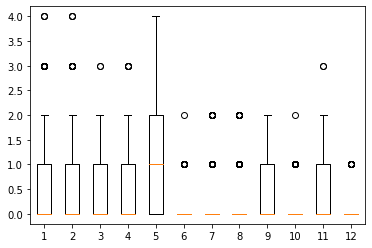

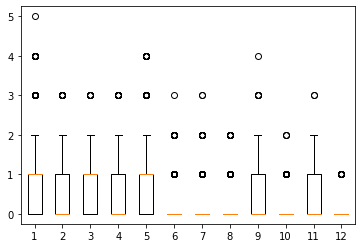

In [39]:
plt.boxplot(cluster0[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()
plt.boxplot(cluster2[['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']])
plt.show()

In [40]:
verticals = df.loc[(df['GO'] == 4)]
sorted(verticals['clusters_agg'].unique().tolist())

[0, 1, 2, 3, 4, 5, 6]

In [41]:
flood = df.loc[(df['CORNER'] == 1) & (df['OUT'] == 1) & (df['FLAT'] == 1) & (df['POST'] == 1)]
sorted(flood['clusters_agg'].unique().tolist())

[0, 2, 3, 5, 6]

In [42]:
slants = df.loc[(df['SLANT'] >= 2)]
sorted(slants['clusters_agg'].unique().tolist())

[0, 2, 3, 4, 5, 6]

In [43]:
def plot_relationship(df, xcol, ycol, labels):
    fig = plt.figure(figsize=(6, 6))
    grid = plt.GridSpec(4, 4, hspace=0.2, wspace=0.2)
    main_ax = fig.add_subplot(grid[:-1, 1:])
    y_hist = fig.add_subplot(grid[:-1, 0], xticklabels=[], sharey=main_ax)
    x_hist = fig.add_subplot(grid[-1, 1:], yticklabels=[], sharex=main_ax)

    main_ax.tick_params(
        axis='both',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=True,      # ticks along the bottom edge are off
        left=True,
        top=False,         # ticks along the top edge are off
        labelbottom=False,
        labelleft=False) # labels along the bottom edge are off
    x = df[xcol]
    y = df[ycol]
    main_ax.scatter(x, y, c=labels)

    x_hist.hist(x, 40, histtype='stepfilled', orientation='vertical', color='gray')
    x_hist.invert_yaxis()
    x_hist.set_xlabel(xcol)

    y_hist.hist(y, 40, histtype='stepfilled', orientation='horizontal', color='gray')
    y_hist.invert_xaxis()
    y_hist.set_ylabel(ycol)

In [44]:
df_columns = df.drop(['gameId', 'playId', 'clusters_agg', 'clusters_kmeans', 'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL'], axis=1).columns.tolist()
#for subset in combinations(df_columns, 2):
    #plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

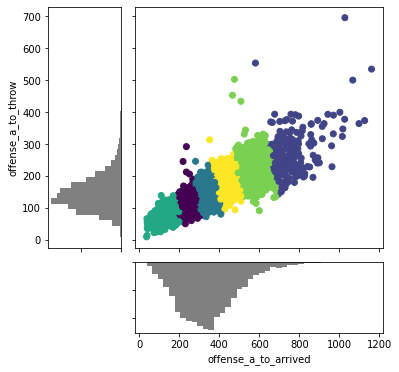

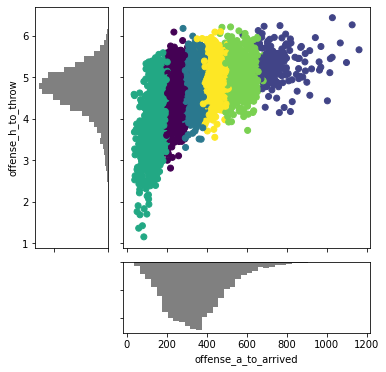

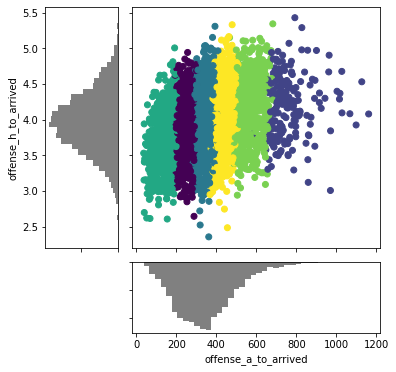

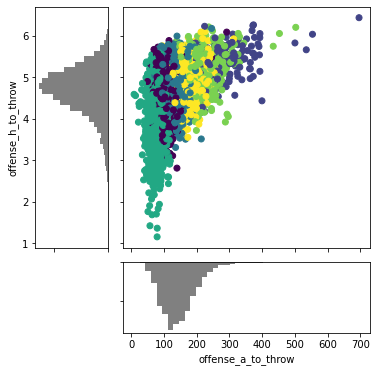

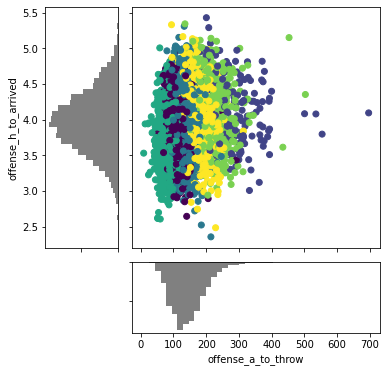

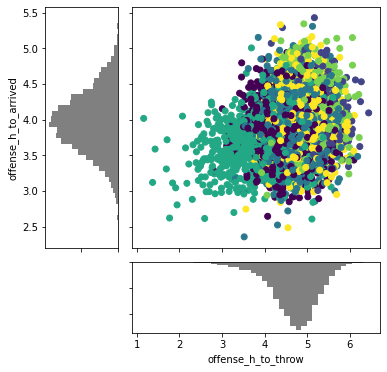

In [45]:
df_columns = df_scaled[['offense_a_to_arrived', 'offense_a_to_throw', 'offense_h_to_throw', 'offense_h_to_arrived']].columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

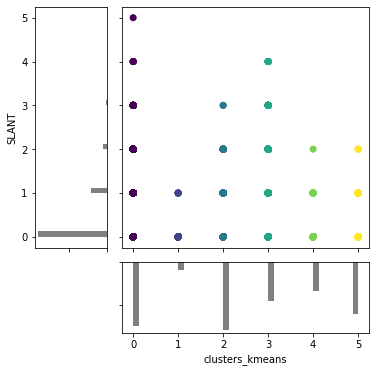

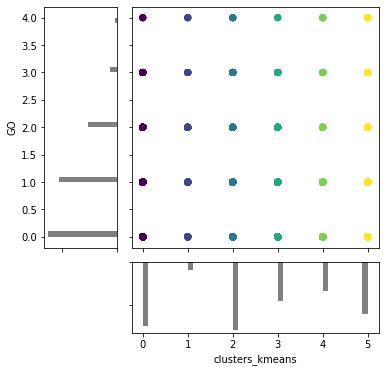

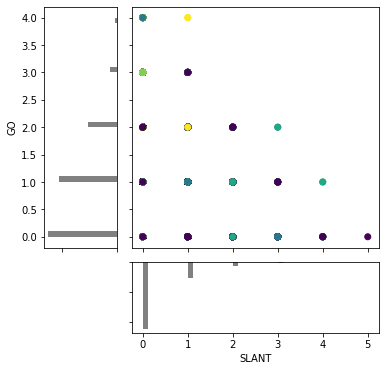

In [46]:
df_columns = df[['clusters_kmeans', 'SLANT', 'GO']].columns.tolist()
for subset in combinations(df_columns, 2):
    plot_relationship(df, subset[0], subset[1], df['clusters_kmeans'])

In [47]:
from mpl_toolkits import mplot3d
#%matplotlib notebook

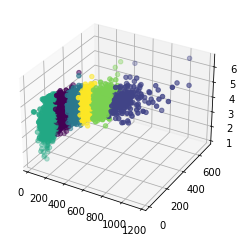

In [48]:
ax = plt.axes(projection='3d')
x = df['offense_a_to_arrived']
y = df['offense_a_to_throw']
z = df['offense_h_to_throw']
ax.scatter3D(x, y, z, c=df['clusters_kmeans'])

## Visualisation of order parameters within clusters

In [49]:
def draw_prob_density(x_series, y_series, x_bins, y_bins, ax, xlab=None, ylab=None, cbar=True):
    dims = {'x': x_series.max() * 1.00001, 'y': y_series.max() * 1.00001}

    bins = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    rows = min(len(y_series), len(x_series))

    for row in range(rows):
        i = int(x_series.iloc[row] / dims['x'] * x_bins)
        j = int(y_series.iloc[row] / dims['y'] * y_bins)
        bins[j][i] += 1

    smoothing_grid = np.zeros(x_bins * y_bins).reshape(y_bins, x_bins)
    for i in range(x_bins):
        for j in range(y_bins):
            sum = 0
            count = 0
            for x in range(-1, 2):
                for y in range(-1, 2):
                    if 0 <= i + x < x_bins and 0 <= j + y < y_bins:
                        sum += bins[j + y][i + x]
                        count += 1
            smoothing_grid[j][i] = sum / count

    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    if cbar:
        c = ax.pcolor(smoothing_grid, cmap='jet')
        plt.colorbar(c, ax=ax)
    else:
        ax.pcolor(smoothing_grid, cmap='jet')

In [50]:
fig_height = 3

In [51]:
df_clustered = play_df[['gameId', 'playId', 'offense_p_play', 'offense_m_play', 'offense_v_play', 'offense_a_play','offense_h_play', 'offense_h_presnap',
              'offense_h_to_throw', 'offense_h_to_arrived',
              'offense_p_presnap', 'offense_p_to_throw', 'offense_p_to_arrived',
              'offense_m_presnap',
              'offense_m_to_throw', 'offense_m_to_arrived', 'offense_v_presnap', 'offense_v_to_throw',
              'offense_v_to_arrived',
              'offense_a_presnap', 'offense_a_to_throw', 'offense_a_to_arrived',
              'HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
              'IN', 'ANGLE', 'POST', 'WHEEL', 'num_routes']].dropna().copy()

df_clustered['cluster'] = km.fit_predict(normalize(df_clustered))
df_clustered['cluster'] = y_km

<AxesSubplot:title={'center':'Distribution of clusters'}, xlabel='Cluster ID', ylabel='Density'>

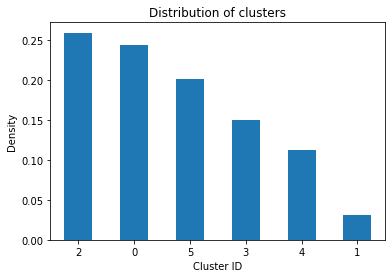

In [52]:
(df_clustered['cluster'].value_counts() / df_clustered['cluster'].value_counts().sum()).plot.bar(rot=0,
                                                                                             title='Distribution of clusters',
                                                                                             xlabel='Cluster ID',
                                                                                             ylabel='Density')

In [53]:
clusters = df_clustered['cluster'].max()

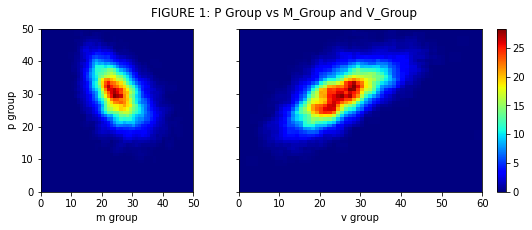

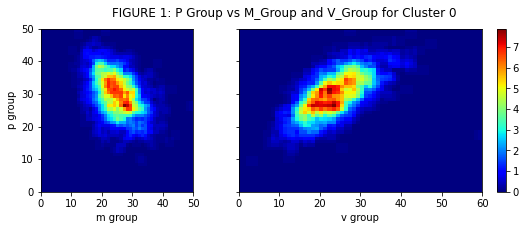

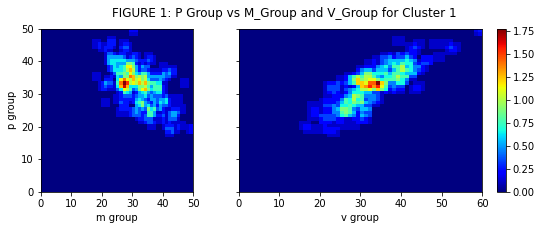

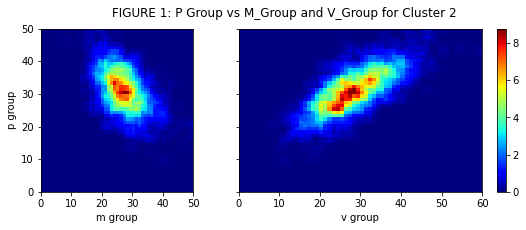

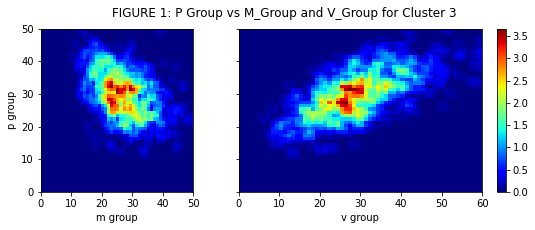

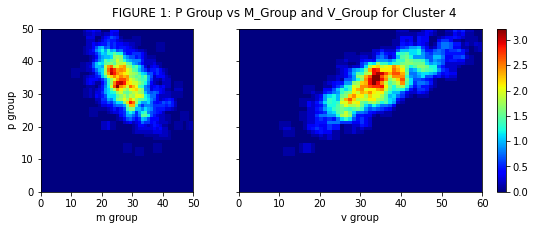

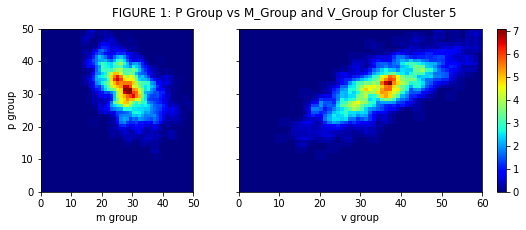

In [68]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                        gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(df_clustered['offense_m_play'], df_clustered['offense_p_play'], 50, 50, axs[0], xlab='m group', ylab='p group', cbar=False)
draw_prob_density(df_clustered['offense_v_play'], df_clustered['offense_p_play'], 60, 50, axs[1], xlab='v group')

fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group')

for cluster in range(clusters + 1):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                            gridspec_kw={'width_ratios': [1, 2]})

    cluster_df = df_clustered[df_clustered['cluster'] == cluster]

    draw_prob_density(cluster_df['offense_m_play'], cluster_df['offense_p_play'], 50, 50, axs[0], xlab='m group', ylab='p group', cbar=False)
    draw_prob_density(cluster_df['offense_v_play'], cluster_df['offense_p_play'], 60, 50, axs[1], xlab='v group')

    fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group for Cluster {cluster}')

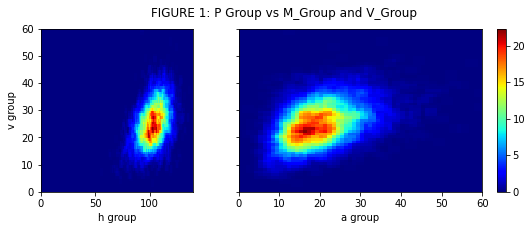

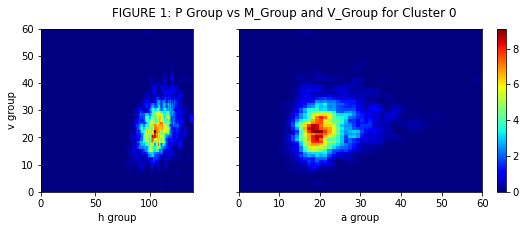

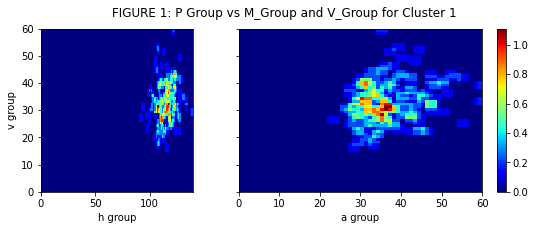

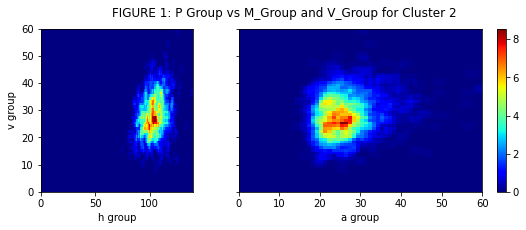

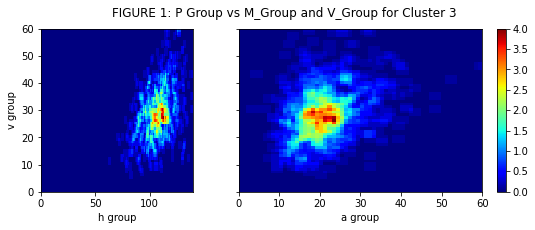

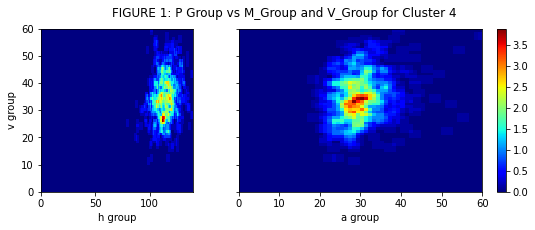

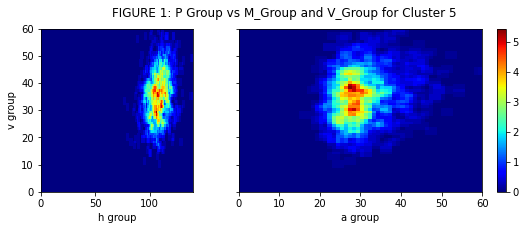

In [55]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                        gridspec_kw={'width_ratios': [1, 2]})

draw_prob_density(df_clustered['offense_h_play'], df_clustered['offense_v_play'], 140, 60, axs[0], xlab='h group', ylab='v group', cbar=False)
draw_prob_density(df_clustered['offense_a_play'], df_clustered['offense_v_play'], 60, 60, axs[1], xlab='a group')

fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group')

for cluster in range(clusters + 1):
    fig, axs = plt.subplots(1, 2, sharey=True, figsize=(3 * fig_height, fig_height),
                            gridspec_kw={'width_ratios': [1, 2]})

    cluster_df = df_clustered[df_clustered['cluster'] == cluster]

    draw_prob_density(cluster_df['offense_h_play'], cluster_df['offense_v_play'], 140, 60, axs[0], xlab='h group', ylab='v group', cbar=False)
    draw_prob_density(cluster_df['offense_a_play'], cluster_df['offense_v_play'], 60, 60, axs[1], xlab='a group')

    fig.suptitle(f'FIGURE 1: P Group vs M_Group and V_Group for Cluster {cluster}')

In [56]:
from scipy.stats import ttest_ind

In [57]:
routes = ['HITCH', 'OUT', 'FLAT', 'CROSS', 'GO', 'SLANT', 'SCREEN', 'CORNER',
       'IN', 'ANGLE', 'POST', 'WHEEL']
p_target = 0.02

route_sig = {'HITCH': 0, 'OUT': 0, 'FLAT': 0, 'CROSS': 0, 'GO': 0, 'SLANT': 0, 'SCREEN': 0, 'CORNER': 0,
       'IN': 0, 'ANGLE': 0, 'POST': 0, 'WHEEL': 0}
grid_dim = clusters + 1
differences = np.zeros(grid_dim ** 2).reshape(grid_dim, grid_dim)

for i in range(clusters + 1):
    for j in range(clusters + 1):
        if not j <= i:
            for route in routes:
                c1 = df_clustered.loc[df_clustered['cluster'] == i][route]
                c2 = df_clustered.loc[df_clustered['cluster'] == j][route]
                p_value = ttest_ind(c1, c2)[1]
                if p_value <= p_target:
                    differences[i][j] += 1
                    route_sig[route] += 1
                    print(f'P-Value for difference between clusters {i} and {j} for the {route} route: {p_value:.4f}')

P-Value for difference between clusters 0 and 1 for the HITCH route: 0.0111
P-Value for difference between clusters 0 and 1 for the GO route: 0.0000
P-Value for difference between clusters 0 and 1 for the SLANT route: 0.0000
P-Value for difference between clusters 0 and 1 for the POST route: 0.0000
P-Value for difference between clusters 0 and 2 for the HITCH route: 0.0000
P-Value for difference between clusters 0 and 2 for the FLAT route: 0.0000
P-Value for difference between clusters 0 and 2 for the CROSS route: 0.0087
P-Value for difference between clusters 0 and 2 for the GO route: 0.0001
P-Value for difference between clusters 0 and 2 for the SLANT route: 0.0000
P-Value for difference between clusters 0 and 2 for the SCREEN route: 0.0000
P-Value for difference between clusters 0 and 2 for the IN route: 0.0000
P-Value for difference between clusters 0 and 2 for the POST route: 0.0000
P-Value for difference between clusters 0 and 3 for the HITCH route: 0.0000
P-Value for difference 

<BarContainer object of 12 artists>

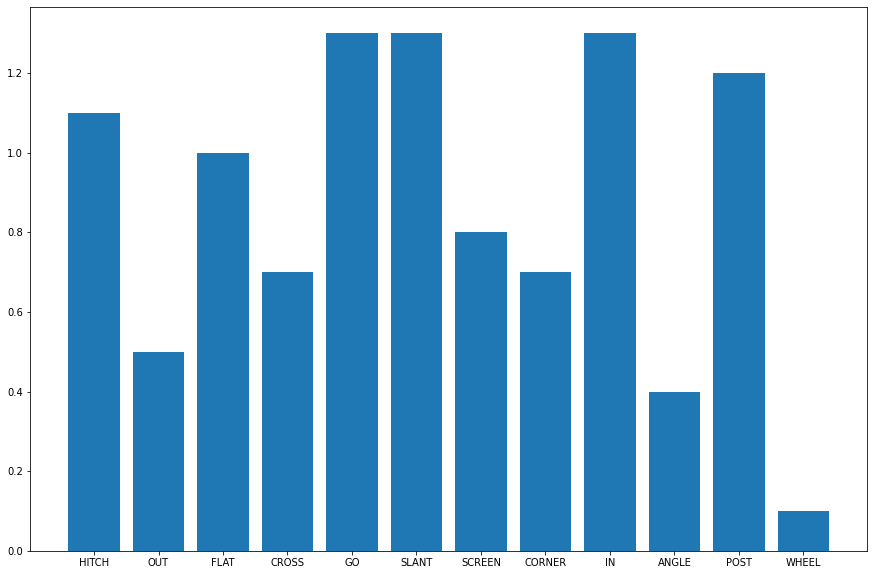

In [70]:
x = route_sig.keys()
y = list(route_sig.values())
fig, ax = plt.subplots(figsize=(15, 10))
ax.bar(x, ( y / ((clusters ** 2 - clusters) / 2)))

In [59]:
differences[:, :]

array([[ 0.,  4.,  8., 10.,  7.,  7.],
       [ 0.,  0.,  7.,  7.,  4.,  5.],
       [ 0.,  0.,  0., 11.,  6.,  5.],
       [ 0.,  0.,  0.,  0., 11., 10.],
       [ 0.,  0.,  0.,  0.,  0.,  2.],
       [ 0.,  0.,  0.,  0.,  0.,  0.]])

In [60]:
df_clustered.loc[df_clustered['cluster'] == 0]['HITCH'].mean()

0.6824093086926762

In [61]:
df_clustered.loc[df_clustered['cluster'] == 1]['HITCH'].mean()

0.5132275132275133

In [62]:
df_clustered.loc[df_clustered['cluster'] == 0][routes].mean()

HITCH     0.682409
OUT       0.461328
FLAT      0.708419
CROSS     0.401095
GO        0.726899
SLANT     0.600274
SCREEN    0.212868
CORNER    0.136893
IN        0.256674
ANGLE     0.155373
POST      0.175222
WHEEL     0.030116
dtype: float64

In [63]:
df_clustered.groupby('cluster')[routes].mean()

,HITCH,OUT,FLAT,CROSS,GO,SLANT,SCREEN,CORNER,IN,ANGLE,POST,WHEEL
cluster,,,,,,,,,,,,
0,0.682409,0.461328,0.708419,0.401095,0.726899,0.600274,0.212868,0.136893,0.256674,0.155373,0.175222,0.030116
1,0.513228,0.497354,0.767196,0.343915,1.301587,0.031746,0.132275,0.179894,0.238095,0.169312,0.460317,0.005291
2,0.830541,0.473582,0.594716,0.465851,0.846005,0.230670,0.137887,0.155284,0.414304,0.152062,0.313144,0.023840
3,0.393973,0.286830,0.890625,0.270089,0.736607,0.627232,0.620536,0.056920,0.085938,0.226562,0.054688,0.011161
4,0.721726,0.514881,0.626488,0.413690,1.065476,0.038690,0.114583,0.211310,0.345238,0.174107,0.419643,0.013393
5,0.820066,0.500829,0.592040,0.378939,0.996683,0.082090,0.140962,0.165008,0.426202,0.189055,0.378109,0.017413


<AxesSubplot:>

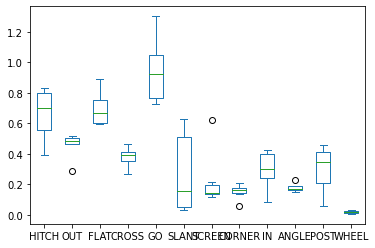

In [64]:
df_clustered.groupby('cluster')[routes].mean().plot.box()